In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

seed = 10599
aqua_globals.random_seed = seed
import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/tmp/ipykernel_10859/3458627689.py:13: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  aqua_globals.random_seed = seed


In [2]:
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.components.feature_maps import RawFeatureVector
from qiskit.circuit.library import TwoLocal
import functools

In [3]:
c_dataset = pd.read_excel('co2_programming_c.xlsx', engine='openpyxl')

c_dataset.head()

,S.NO,REGISTER NO.,NAMES,MS 1 40%,MS 2 20%,Attendance %,SEM RESULT 44%,TOTAL 164%,OBTAINED FOR 100,Threshold 60%
0,1,15 51 001,AARTHI.P.,27.2,18.4,93,39.6,125.2,76.341463,Y
1,2,15 51 002,ABDUL KHADI.K.,14.4,3.6,93,11.0,69.0,42.073171,N
2,3,15 51 003,ABINAYA.N.,31.2,16.0,97,39.6,126.8,77.317073,Y
3,4,15 51 004,AKALYA.M.,20.0,4.4,93,26.4,90.8,55.365854,N
4,5,15 51 005,ARCHANADEVI@KAMATCHI R.,28.8,15.2,93,35.2,119.2,72.682927,Y


In [4]:
df = c_dataset.copy()
df['Threshold 60%'].replace(to_replace=['Y', 'N'], value=[1, 0], inplace=True)
df.drop(['S.NO', 'REGISTER NO.','NAMES'], axis=1,inplace = True)
df.head()

,MS 1 40%,MS 2 20%,Attendance %,SEM RESULT 44%,TOTAL 164%,OBTAINED FOR 100,Threshold 60%
0,27.2,18.4,93,39.6,125.2,76.341463,1
1,14.4,3.6,93,11.0,69.0,42.073171,0
2,31.2,16.0,97,39.6,126.8,77.317073,1
3,20.0,4.4,93,26.4,90.8,55.365854,0
4,28.8,15.2,93,35.2,119.2,72.682927,1


<AxesSubplot:>

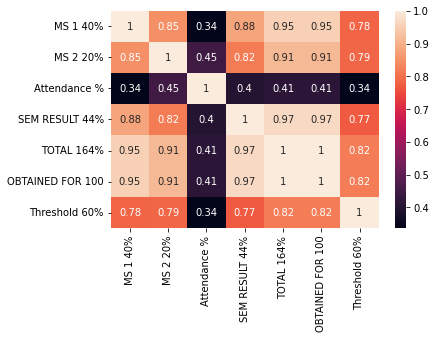

In [5]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, annot=True)

In [6]:
df.drop(['Attendance %'], axis = 1, inplace = True)
df.columns

Index(['MS 1 40%', 'MS 2 20%', 'SEM RESULT 44%', 'TOTAL 164%',
       'OBTAINED FOR 100', 'Threshold 60%'],
      dtype='object')

In [7]:
vals = df[df.columns[:-1]].values

# QSVM

In [8]:
def custom_data_map_func(x):
    """Define a function map from R^n to R.
    
    Args:
        x (np.ndarray): data
    Returns:
        double: the mapped value
    """
    coeff = x[0] if len(x) == 1 else functools.reduce(lambda m, n: m * n, np.pi - x)
    return coeff

In [9]:
train_input = vals[:25]
test_input = vals[25:]

training_data = {1:[],0:[]} # 1 == 'A' and 0 == 'B'
for i in range(len(train_input)):
    if df['Threshold 60%'][i] == 1:
        training_data[1].append(train_input[i].tolist())
    else:
        training_data[0].append(train_input[i].tolist())
        
testing_data = {1:[],0:[]} # 1 == 'A' and 0 == 'B'
for i in range(len(test_input)):
    if df['Threshold 60%'][i] == 1:
        testing_data[1].append(test_input[i].tolist())
    else:
        testing_data[0].append(test_input[i].tolist())

In [10]:
def qsvm_testing_accuracy(training_data, testing_data, feature_dim, reps, entanglement):
    feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=reps, entanglement=entanglement,  data_map_func=custom_data_map_func)
    
    qsvm = QSVM(feature_map, training_data, testing_data)

    backend = BasicAer.get_backend('qasm_simulator')
    quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
    result = qsvm.run(quantum_instance)
    print('Testing Accuracy for reps={} and entanglement={}: '.format(reps, entanglement), result['testing_accuracy'])
    return

In [11]:
lst = ['linear', 'circular', 'full']

feature_dim = 5

for i in range(len(lst)):
    for j in lst:
        qsvm_testing_accuracy(training_data, testing_data, feature_dim, i+1, j)


Testing Accuracy for reps=1 and entanglement=linear:  0.625
Testing Accuracy for reps=1 and entanglement=circular:  0.625
Testing Accuracy for reps=1 and entanglement=full:  0.6875
Testing Accuracy for reps=2 and entanglement=linear:  0.6875
Testing Accuracy for reps=2 and entanglement=circular:  0.6875
Testing Accuracy for reps=2 and entanglement=full:  0.6875
Testing Accuracy for reps=3 and entanglement=linear:  0.625
Testing Accuracy for reps=3 and entanglement=circular:  0.6875
Testing Accuracy for reps=3 and entanglement=full:  0.6875


In [12]:
reps = 2
entanglement = 'linear'
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=reps, entanglement=entanglement,  data_map_func=custom_data_map_func)
    
final_qsvm = QSVM(feature_map, training_data, testing_data)

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
result = final_qsvm.run(quantum_instance)
result['testing_accuracy']

0.6875

# VQC

In [13]:
from qiskit.aqua.algorithms import VQC

In [14]:
feature_dim = 5

#feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='full')
#feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=2, paulis=['ZZ'])
feature_map = RawFeatureVector(feature_dimension=feature_dim)

vqc = VQC(COBYLA(maxiter=100),
          feature_map,
          TwoLocal(feature_map.num_qubits, ['ry', 'rz'], 'cz', reps=3),
          training_dataset = training_data,
          test_dataset = testing_data)

result = vqc.run(QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                 shots=1024, seed_simulator=seed, seed_transpiler=seed))

print('Testing accuracy: {:0.2f}'.format(result['testing_accuracy']))
print(result)

Testing accuracy: 0.75
{'num_optimizer_evals': 100, 'min_val': 0.5277471856189987, 'opt_params': array([ 1.57852891,  1.92310118, -0.42682029, -0.31841217,  1.44032704,
       -0.15592288, -0.61309153,  2.70540931, -0.23023543, -0.18415167,
        1.34081528, -1.27376323,  1.37152194,  2.39563254,  1.21393098,
        1.37105105, -0.41897163, -0.99448067,  0.0061347 , -0.73475107,
        0.13564644, -0.24821966,  0.77254019,  0.5340008 ]), 'eval_time': 172.25425267219543, 'eval_count': 100, 'training_loss': 0.5277471856189987, 'testing_accuracy': 0.75, 'test_success_ratio': 0.75, 'testing_loss': 0.5902862291956963}


VQC performed better than QSVM